In [1]:
import pandas as pd
import numpy as np

# ---------------------- 1. 数据读取与预处理 ----------------------
# 读取Excel文件（请替换为你的文件路径）
df = pd.read_excel("result.xlsx", sheet_name="Sheet1")

core_cols = [
    # 行为字段（原有）
    " 您平均每周观看微短剧的时长约为",
    " 您观看微短剧的频率大致为",
    " 您过去一月为微短剧付费的总金额",
    " 您目前平均每周通过“广告解锁”观看微短剧的次数",
    " 您是否观看过微短剧",
    # 特征字段（新增，需替换为你Excel中的实际列名）
    " 您的性别是",          # 示例列名，如：1=男，2=女
    " 您的年级是",          # 示例列名，如：1=专科，2=本科，3=硕士
    " 您的专业是",      # 示例列名，如：1=文科，2=理科，3=工科，4=艺术类
    # " 您主要观看微短剧的平台"  # 示例列名，如：1=抖音，2=快手，3=番茄短剧，4=腾讯微视
]

df_clean = df[core_cols]

# ---------------------- 2. 细分指标定义 ----------------------
# 2.1 观看依赖度定义（高频=高依赖，否则=低依赖/零观看）
def define_watch_dependency(row):
    # 已观看用户：时长≥3小时（假设选项3对应≥3小时）且频率≥3次/周（选项3对应≥3次）
    if row[" 您是否观看过微短剧"] == 1:  # 1=观看过，2=未观看
        if row[" 您平均每周观看微短剧的时长约为"] >= 3 and row[" 您观看微短剧的频率大致为"] <= 3:
            return "高依赖"
        else:
            return "低依赖"
    else:
        return "零观看"

# 2.2 付费行为定义（有付费/仅广告解锁/无付费意愿）
def define_payment_behavior(row):
    """
    严格以「付费相关行为」定义，排除单纯观看意愿：
    1. 有付费：历史付费＞0（实际发生过付费）
    2. 仅广告解锁：无历史付费 + 每周广告解锁≥1次（免费但有观看行为）
    3. 无付费意愿：无历史付费 + 无广告解锁（既不付费也不看广告解锁，纯免费/零观看）
    """
    # 有付费：历史付费>0 或 未来愿意付费（假设≥3分为愿意，5分制）
    if row[" 您过去一月为微短剧付费的总金额"] > 1:
        return "有付费"
    # 仅广告解锁：广告解锁次数≥1 且 无付费行为
    elif row[" 您目前平均每周通过“广告解锁”观看微短剧的次数"] > 1:
        return "仅广告解锁"
    else:
        return "无付费"

# ---------------------- 3. 群体划分 ----------------------
# 应用定义函数生成指标列
df_clean["观看依赖度"] = df_clean.apply(define_watch_dependency, axis=1)
df_clean["付费行为"] = df_clean.apply(define_payment_behavior, axis=1)

# 定义四类群体的划分规则
def classify_user(row):
    if row["观看依赖度"] == "高依赖" and row["付费行为"] in ["有付费"]:
        return "高依赖付费用户"
    elif row["观看依赖度"] == "高依赖" and row["付费行为"] == "仅广告解锁":
        return "高依赖潜在付费用户"
    elif row["观看依赖度"] == "高依赖" and row["付费行为"] in ['无付费']:
        return "高依赖免费用户"
    elif row["观看依赖度"] == "低依赖" and row["付费行为"] == "无付费":
        return "低依赖无付费用户"
    elif row["观看依赖度"] == "零观看":
        return "零观看用户"
    elif row["观看依赖度"] == "低依赖" and row["付费行为"] in ["仅广告解锁"]:
        return "低依赖潜在付费用户"
    elif row["观看依赖度"] == "低依赖" and row["付费行为"] == "有付费":
        return "低依赖付费用户"
    else:
        return "其他"  # 异常样本兜底

# 生成群体标签列
df_clean["用户群体"] = df_clean.apply(classify_user, axis=1)

# ---------------------- 4. 统计结果输出 ----------------------
# 计算各群体数量与占比
group_stats = df_clean["用户群体"].value_counts().reset_index()
group_stats.columns = ["用户群体", "样本数"]
group_stats["占比(%)"] = round(group_stats["样本数"] / len(df_clean) * 100, 1)

# 打印统计结果
print("=== 上海市大学生微短剧用户细分统计结果 ===")
print(group_stats.to_string(index=False))

# 保存结果到新Excel（可选）
group_stats.to_excel("用户细分统计结果.xlsx", index=False)
print("\n统计结果已保存至：用户细分统计结果.xlsx")

=== 上海市大学生微短剧用户细分统计结果 ===
     用户群体  样本数  占比(%)
  低依赖付费用户  204   34.8
  高依赖付费用户  110   18.8
    零观看用户  100   17.1
低依赖潜在付费用户   94   16.0
 低依赖无付费用户   44    7.5
高依赖潜在付费用户   28    4.8
  高依赖免费用户    6    1.0

统计结果已保存至：用户细分统计结果.xlsx


C:\Users\26935\AppData\Local\Temp\ipykernel_29492\3764535527.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["观看依赖度"] = df_clean.apply(define_watch_dependency, axis=1)
C:\Users\26935\AppData\Local\Temp\ipykernel_29492\3764535527.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["付费行为"] = df_clean.apply(define_payment_behavior, axis=1)
C:\Users\26935\AppData\Local\Temp\ipykernel_29492\3764535527.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [2]:
# 交叉分析：观看依赖度 vs 付费行为
cross_analysis = pd.crosstab(df_clean["观看依赖度"], df_clean["付费行为"], margins=True)
cross_analysis["占比(%)"] = round(cross_analysis["All"] / len(df_clean) * 100, 1)
print("\n=== 观看依赖度×付费行为交叉分析 ===")
print(cross_analysis)


=== 观看依赖度×付费行为交叉分析 ===
付费行为   仅广告解锁  无付费  有付费  All  占比(%)
观看依赖度                             
低依赖       94   44  204  342   58.4
零观看        0  100    0  100   17.1
高依赖       28    6  110  144   24.6
All      122  150  314  586  100.0


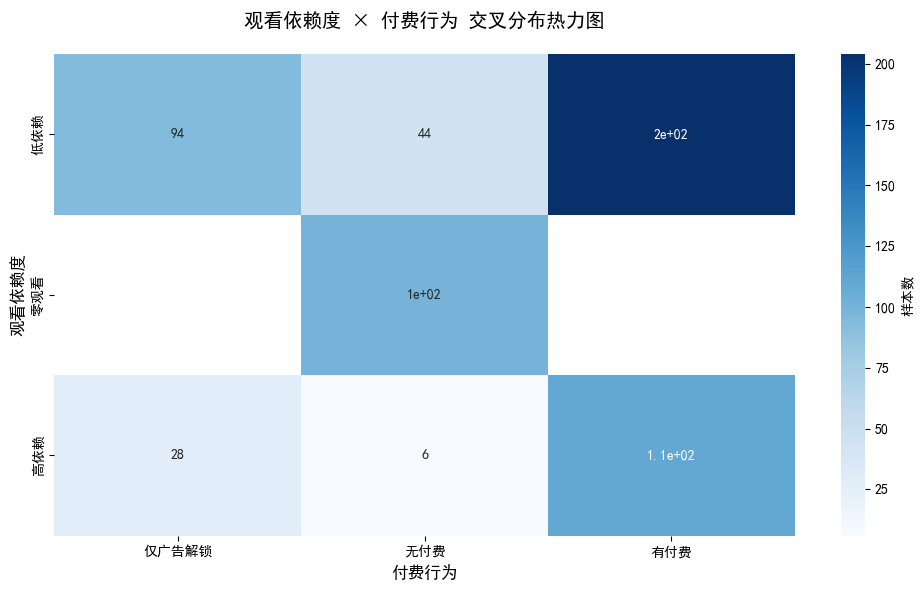

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
# ---------------------- 5. 热力图绘制 ----------------------
# 设置中文字体（避免乱码）
plt.rcParams["font.family"] = ["SimHei"]  # Windows/Mac适配
plt.rcParams["axes.unicode_minus"] = False
# 5.1 热力图1：观看依赖度 × 付费行为 交叉计数热力图（核心维度）
cross_tab = pd.crosstab(df_clean["观看依赖度"], df_clean["付费行为"], values=df_clean.index, aggfunc="count")
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, cmap="Blues", cbar_kws={"label": "样本数"})
plt.title("观看依赖度 × 付费行为 交叉分布热力图", fontsize=14, pad=20)
plt.xlabel("付费行为", fontsize=12)
plt.ylabel("观看依赖度", fontsize=12)
plt.tight_layout()
plt.savefig("依赖度_付费行为_热力图.png", dpi=300, bbox_inches="tight")

付费行为列顺序： ['仅广告解锁', '无付费', '有付费']


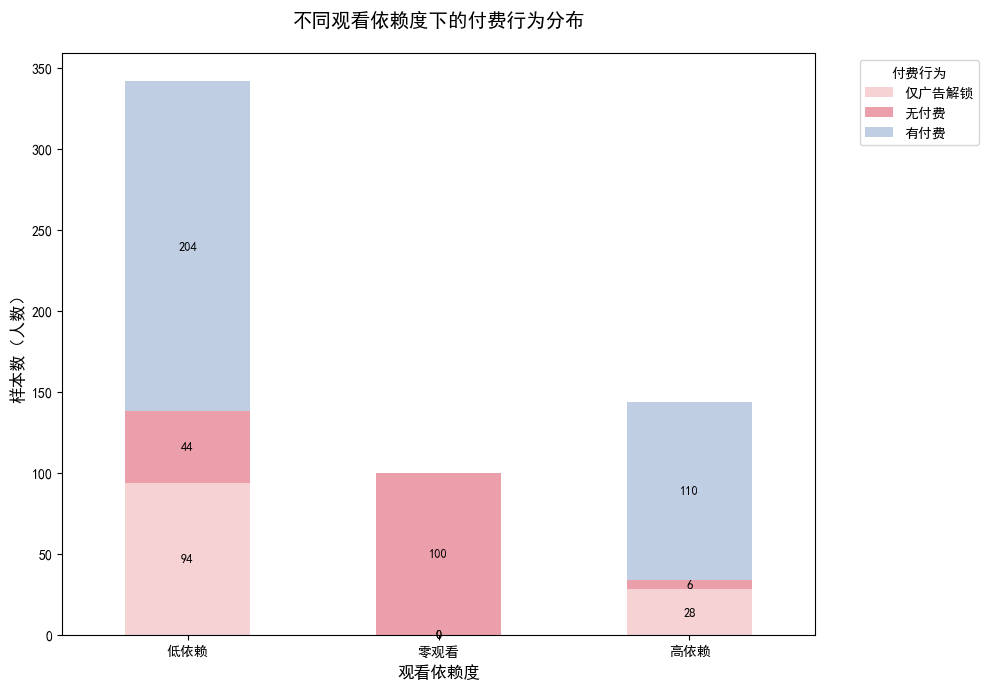

In [4]:
# 5.2 堆叠柱状图：观看依赖度（横轴）× 付费行为（堆叠）× 人数（纵轴）
stack_data = pd.crosstab(df_clean["观看依赖度"], df_clean["付费行为"])
# 查看付费行为的列顺序（确保颜色列表顺序匹配）
print("付费行为列顺序：", stack_data.columns.tolist())
# 自定义颜色列表（顺序需与列顺序一致，示例：有付费=红色，潜在付费=橙色，无付费=浅灰色）
custom_colors = ["#F7D2D5","#EB9FAA", "#C0CEE4"]  # 十六进制色值（推荐）
# 也可使用颜色名称：["red", "orange", "lightgray"]
# 或RGB：[(0.91, 0.30, 0.24), (0.95, 0.61, 0.07), (0.58, 0.65, 0.66)]

plt.figure(figsize=(10, 7))
# 关键：添加color参数指定自定义颜色
stack_data.plot(kind="bar", stacked=True, color=custom_colors, ax=plt.gca())

# 图表样式优化（其余不变）
plt.title("不同观看依赖度下的付费行为分布", fontsize=14, pad=20)
plt.xlabel("观看依赖度", fontsize=12)
plt.ylabel("样本数（人数）", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="付费行为", bbox_to_anchor=(1.05, 1), loc="upper left")

# 数值标注
for container in plt.gca().containers:
    plt.gca().bar_label(container, label_type="center", fontsize=9)

plt.tight_layout()
plt.savefig("依赖度_付费行为_堆叠柱状图.png", dpi=300, bbox_inches="tight")

In [5]:
df_clean[df_clean['用户群体'] == '其他']

,您平均每周观看微短剧的时长约为,您观看微短剧的频率大致为,您过去一月为微短剧付费的总金额,您目前平均每周通过“广告解锁”观看微短剧的次数,您是否观看过微短剧,您的性别是,您的年级是,您的专业是,观看依赖度,付费行为,用户群体


=== 各用户群体特征相对占比统计（%）===
说明：数值=「群体内某特征数 / 总体该特征数 × 100%」

【高依赖付费用户】
  性别：{2: 21.68, 1: 16.0}
  学历：{3: 33.33, 1: 26.83, 4: 14.89, 6: 25.0, 9: 28.57, 2: 8.89, 5: 8.0, 7: 16.67}
  专业类别：{10: 34.78, 9: 18.42, 3: 29.17, 1: 16.22, 5: 25.0, 4: 14.29, 11: 17.24, 6: 41.67, 13: 11.76, 7: 8.33, 8: 6.45, 12: 33.33}
--------------------------------------------------------------------------------
【高依赖潜在付费用户】
  性别：{1: 6.67, 2: 2.8}
  学历：{3: 10.42, 5: 6.0, 4: 6.38, 2: 2.22, 9: 7.14, 8: 16.67}
  专业类别：{10: 17.39, 8: 9.68, 1: 8.11, 7: 8.33, 13: 5.88, 5: 5.0}
--------------------------------------------------------------------------------
【高依赖免费用户】
  性别：{2: 2.1}
  学历：{3: 2.08, 7: 5.56, 2: 2.22}
  专业类别：{5: 5.0, 10: 4.35, 11: 3.45}
--------------------------------------------------------------------------------
【低依赖付费用户】
  性别：{1: 38.67, 2: 30.77}
  学历：{2: 48.89, 1: 46.34, 4: 34.04, 3: 27.08, 6: 41.67, 5: 14.0, 7: 33.33, 9: 42.86, 8: 50.0}
  专业类别：{4: 54.29, 9: 36.84, 11: 41.38, 1: 27.03, 7: 37.5, 13: 41.18, 5:

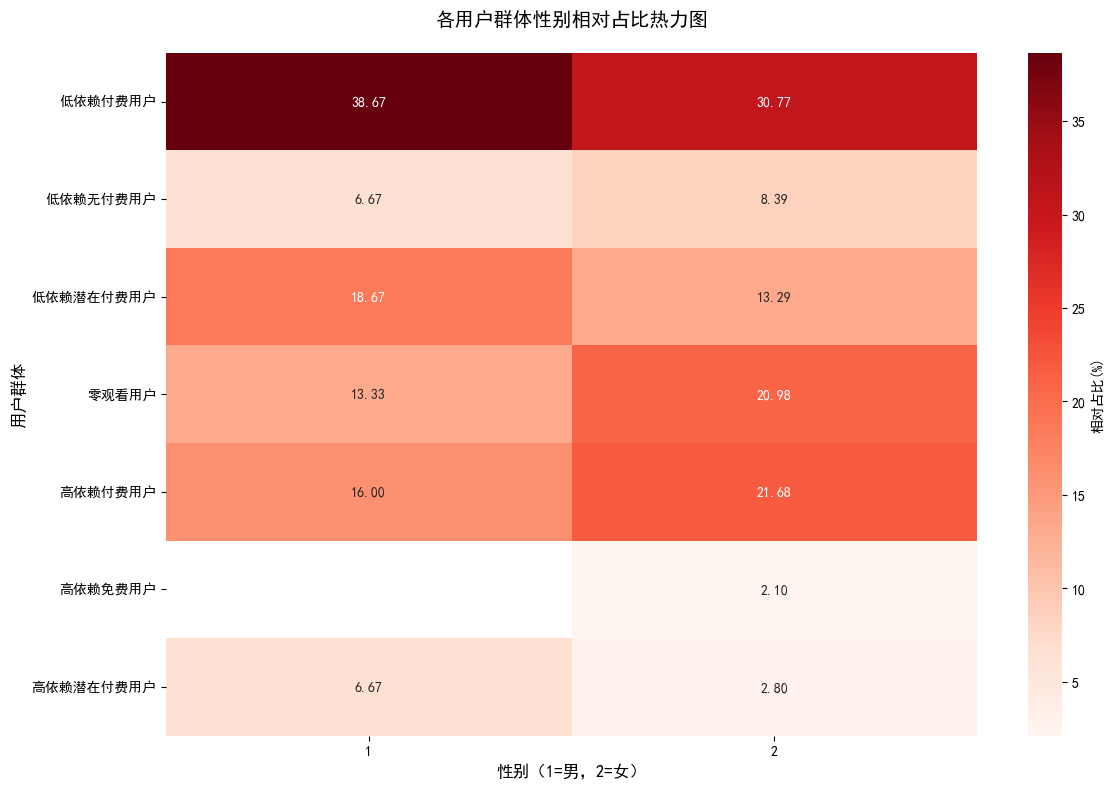

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------- 1. 数据读取与预处理（补充特征列） ----------------------
# df = pd.read_excel("result.xlsx", sheet_name="Sheet1")

# 核心字段：保留原有行为字段 + 新增人口统计/平台字段（请根据实际列名调整！）
core_cols = [
    # 行为字段（原有）
    " 您平均每周观看微短剧的时长约为",
    " 您观看微短剧的频率大致为",
    " 您过去一月为微短剧付费的总金额",
    " 您目前平均每周通过“广告解锁”观看微短剧的次数",
    " 您是否观看过微短剧",
    # 特征字段（新增，需替换为你Excel中的实际列名）
    " 您的性别是",          # 示例列名，如：1=男，2=女
    " 您的年级是",          # 示例列名，如：1=专科，2=本科，3=硕士
    " 您的专业是",      # 示例列名，如：1=文科，2=理科，3=工科，4=艺术类
    # " 您主要观看微短剧的平台"  # 示例列名，如：1=抖音，2=快手，3=番茄短剧，4=腾讯微视
]
# df_clean = df

# 剔除异常群体（仅保留7类核心群体）
df_clean = df_clean[df_clean["用户群体"] != "其他"]

# ---------------------- 3. 计算总体特征总数（分母） ----------------------
# 定义需要统计的特征列表
features = {
    "性别": " 您的性别是",
    "学历": " 您的年级是",
    "专业类别": " 您的专业是",
    # "观看平台": " 您主要观看微短剧的平台"
}

# 计算每个特征类别的总体数量（例如：总体男性数、总体本科数等）
total_feature_counts = {}
for feat_name, feat_col in features.items():
    total_feature_counts[feat_name] = df_clean[feat_col].value_counts().to_dict()

# ---------------------- 4. 计算各群体的特征相对占比 ----------------------
# 初始化结果字典
group_feature_ratio = {}

# 遍历每个核心群体
groups = [
    "高依赖付费用户", "高依赖潜在付费用户", "高依赖免费用户",
    "低依赖付费用户", "低依赖潜在付费用户", "低依赖无付费用户",
    "零观看用户"
]

for group in groups:
    # 筛选该群体的样本
    group_df = df_clean[df_clean["用户群体"] == group]
    group_feature_ratio[group] = {}
    
    # 遍历每个特征，计算相对占比
    for feat_name, feat_col in features.items():
        # 该群体的特征计数（例如：高依赖付费用户中的男性数）
        group_feat_count = group_df[feat_col].value_counts().to_dict()
        # 计算相对占比（群体特征数 / 总体特征数 × 100%）
        ratio_dict = {}
        for feat_val, count in group_feat_count.items():
            if feat_val == 0:  # 跳过缺失值填充的0
                continue
            total_count = total_feature_counts[feat_name].get(feat_val, 1)  # 避免分母为0
            ratio = round(count / total_count * 100, 2)  # 保留2位小数
            ratio_dict[feat_val] = ratio
        group_feature_ratio[group][feat_name] = ratio_dict

# ---------------------- 5. 结果格式化输出 ----------------------
# （1）打印文本版结果
print("=== 各用户群体特征相对占比统计（%）===")
print("说明：数值=「群体内某特征数 / 总体该特征数 × 100%」\n")

for group in groups:
    print(f"【{group}】")
    for feat_name in features.keys():
        print(f"  {feat_name}：{group_feature_ratio[group].get(feat_name, {})}")
    print("-" * 80)

# （2）整理为DataFrame并保存到Excel（更易阅读）
# 构建结果表格
result_rows = []
for group in groups:
    for feat_name in features.keys():
        feat_ratio = group_feature_ratio[group][feat_name]
        for feat_val, ratio in feat_ratio.items():
            result_rows.append({
                "用户群体": group,
                "特征类型": feat_name,
                "特征值": feat_val,
                "相对占比(%)": ratio
            })

result_df = pd.DataFrame(result_rows)
# 按用户群体+特征类型排序
result_df = result_df.sort_values(by=["用户群体", "特征类型"])
# 保存到Excel
result_df.to_excel("用户群体特征相对占比统计.xlsx", index=False)
print("\n统计结果已保存至：用户群体特征相对占比统计.xlsx")

# ---------------------- 6. 可视化：特征占比对比热力图（可选） ----------------------
# 以“性别”为例绘制热力图（可替换为学历/专业/平台）
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

# 提取性别特征的占比数据
gender_data = result_df[result_df["特征类型"] == "性别"].pivot(
    index="用户群体", columns="特征值", values="相对占比(%)"
)

# 绘制热力图
plt.figure(figsize=(12, 8))
sns.heatmap(gender_data, annot=True, fmt=".2f", cmap="Reds", cbar_kws={"label": "相对占比(%)"})
plt.title("各用户群体性别相对占比热力图", fontsize=14, pad=20)
plt.xlabel("性别（1=男，2=女）", fontsize=12)
plt.ylabel("用户群体", fontsize=12)
plt.tight_layout()
plt.savefig("用户群体性别占比热力图.png", dpi=300, bbox_inches="tight")
print("性别占比热力图已保存：用户群体性别占比热力图.png")

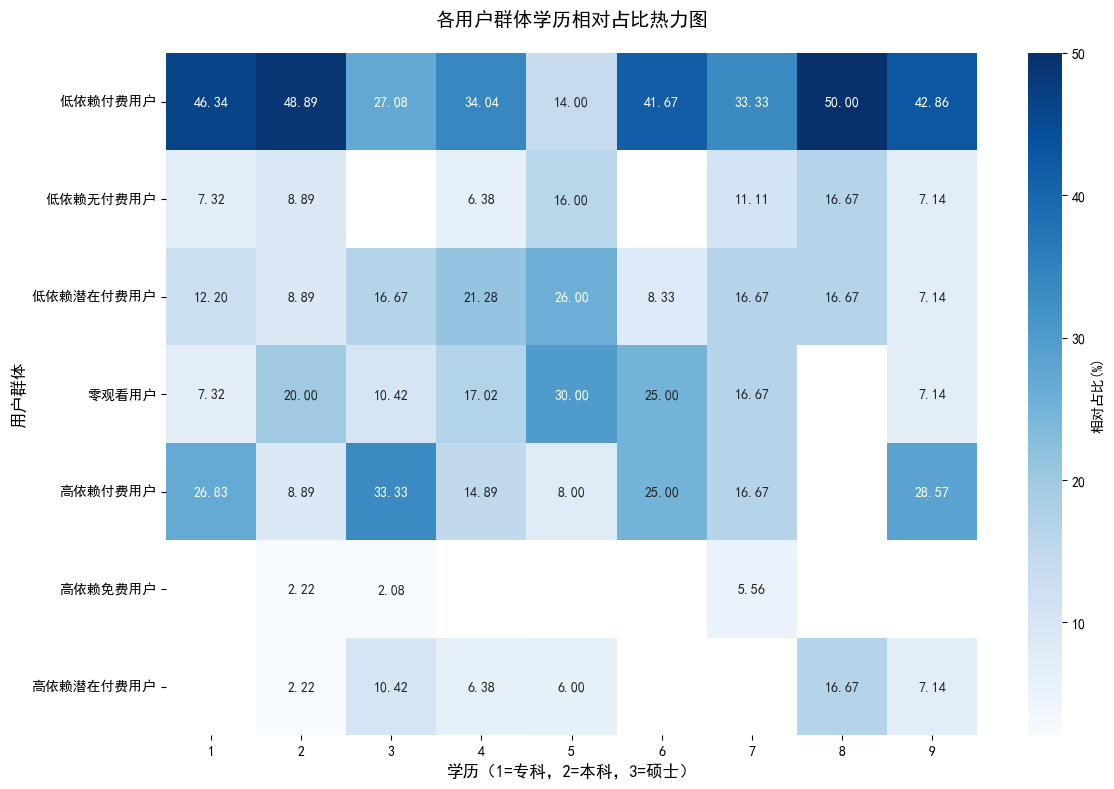

In [7]:
# 学历占比热力图
edu_data = result_df[result_df["特征类型"] == "学历"].pivot(
    index="用户群体", columns="特征值", values="相对占比(%)"
)
plt.figure(figsize=(12, 8))
sns.heatmap(edu_data, annot=True, fmt=".2f", cmap="Blues", cbar_kws={"label": "相对占比(%)"})
plt.title("各用户群体学历相对占比热力图", fontsize=14, pad=20)
plt.xlabel("学历（1=专科，2=本科，3=硕士）", fontsize=12)
plt.ylabel("用户群体", fontsize=12)
plt.tight_layout()
plt.savefig("用户群体学历占比热力图.png", dpi=300, bbox_inches="tight")

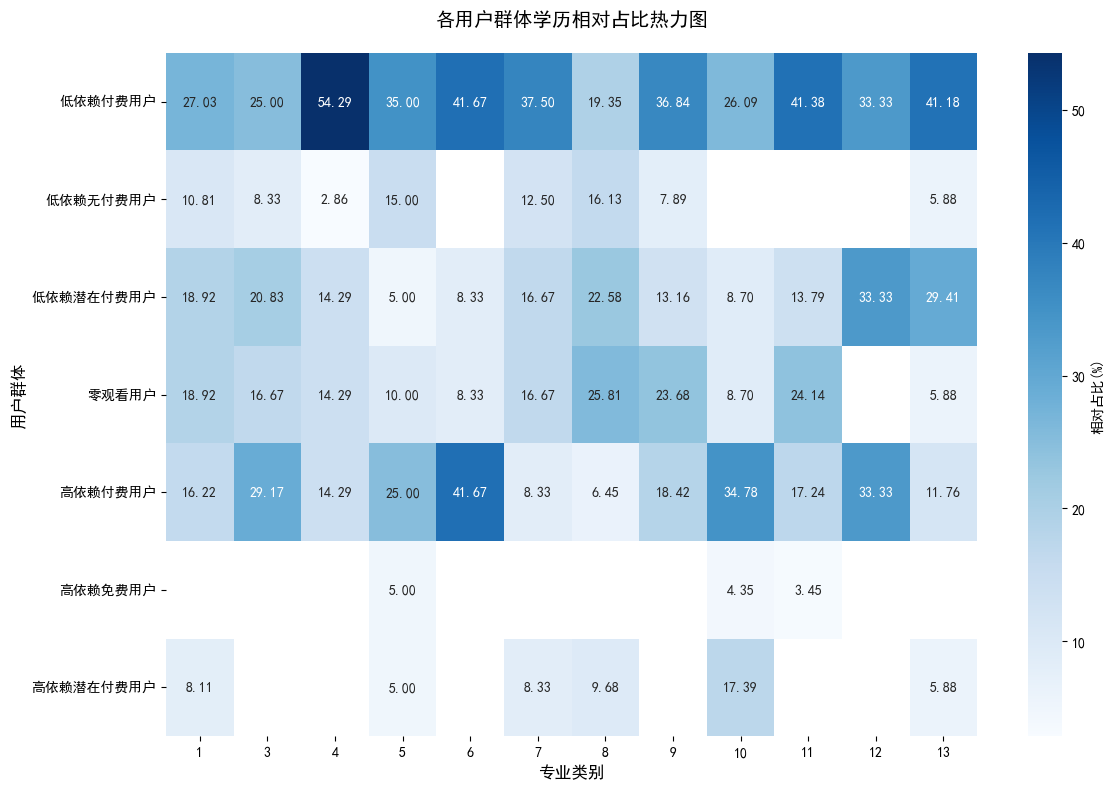

In [8]:
# 学历占比热力图
edu_data = result_df[result_df["特征类型"] == "专业类别"].pivot(
    index="用户群体", columns="特征值", values="相对占比(%)"
)
plt.figure(figsize=(12, 8))
sns.heatmap(edu_data, annot=True, fmt=".2f", cmap="Blues", cbar_kws={"label": "相对占比(%)"})
plt.title("各用户群体学历相对占比热力图", fontsize=14, pad=20)
plt.xlabel("专业类别", fontsize=12)
plt.ylabel("用户群体", fontsize=12)
plt.tight_layout()
plt.savefig("用户群体学历占比热力图.png", dpi=300, bbox_inches="tight")

=== 数据集中所有列名 ===
1. 来源
2. 序号
3. 提交答卷时间
4. 所用时间
5. 总分
6.  您的性别是
7.  您的年级是
8.  您的年龄是
9.  您的专业是
10.  您是否观看过微短剧
11.  您平均每周观看微短剧的时长约为
12.  您观看微短剧的频率大致为
13.  您主要通过哪些平台观看微短剧（可多选）(抖音)
14. 8(快手)
15. 8(番茄短剧)
16. 8(微信视频号)
17. 8(哔哩哔哩)
18. 8(腾讯短剧)
19. 8(爱奇艺短剧)
20. 8(优酷短剧)
21. 8(星芽短剧)
22. 8(河马剧场)
23. 8(其他)
24.  您更偏好以下哪些题材的微短剧（可多选）(甜宠恋爱)
25. 9(复仇逆袭)
26. 9(校园生活)
27. 9(悬疑推理)
28. 9(家庭伦理)
29. 9(其他)
30.  您通常通过哪种方式发现微短剧（可多选）(平台算法推荐)
31. 10(朋友/同学推荐)
32. 10(社交平台(如微博、小红书)种草)
33. 10(广告推广)
34. 10(其他)
35.  您计划未来继续观看微短剧的意愿程度
36.  请根据您的实际感受选择符合的选项—微短剧平台推送的内容很符合我的兴趣
37. 微短剧平台操作方便、播放流畅
38. 微短剧平台的弹幕、评论等互动功能很活跃
39. 微短剧剧情反转多、“爽点”密集
40. 微短剧平台推送的内容不能吸引我
41. 大部分微短剧的剧情和套路都比较相似
42. 微短剧的演员表现、画面质量等制作水平高
43. 微短剧的题材新颖、符合我的喜好
44. 微短剧单部更新快、上新数量多
45. 微短剧广告解锁的时长(如30秒、1分钟)在我可接受范围内
46. 微短剧单集价格或者周月卡价格在我可接受范围内
47. 相比直接付费，我更愿意通过看广告解锁微短剧内容
48. 微短剧的内容同质化让我觉得没必要为其付费
49. 微短剧的剧情长度(单集2-3分钟)不足以让我愿意付费解锁
50. 微短剧平台的促销活动(如折扣、满减)很有吸引力
51. 我常在社交媒体上看到微短剧相关的热门内容
52. 同学、朋友经常推荐我观看微短剧
53. 我所在的社交平台群里常讨论微短剧
54.  请根据您的心理感受与认知选择符合的选项 —观看微短剧能满足我的休闲娱乐需求
55. 我已

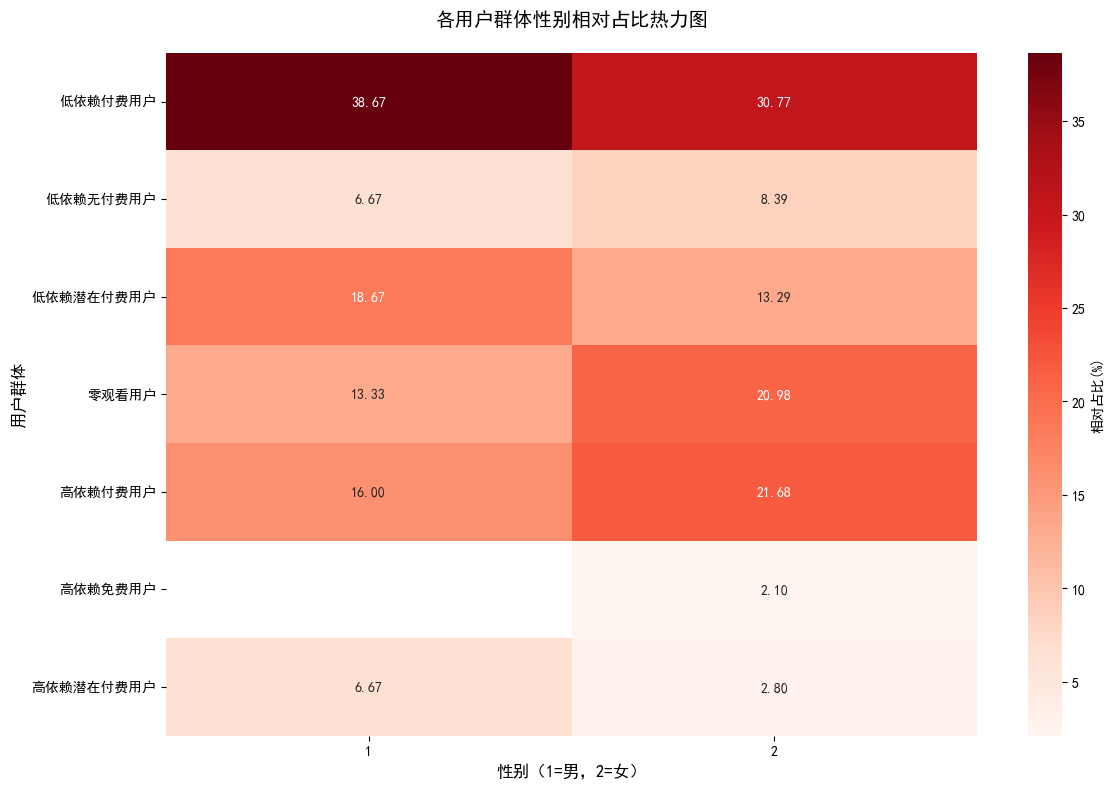

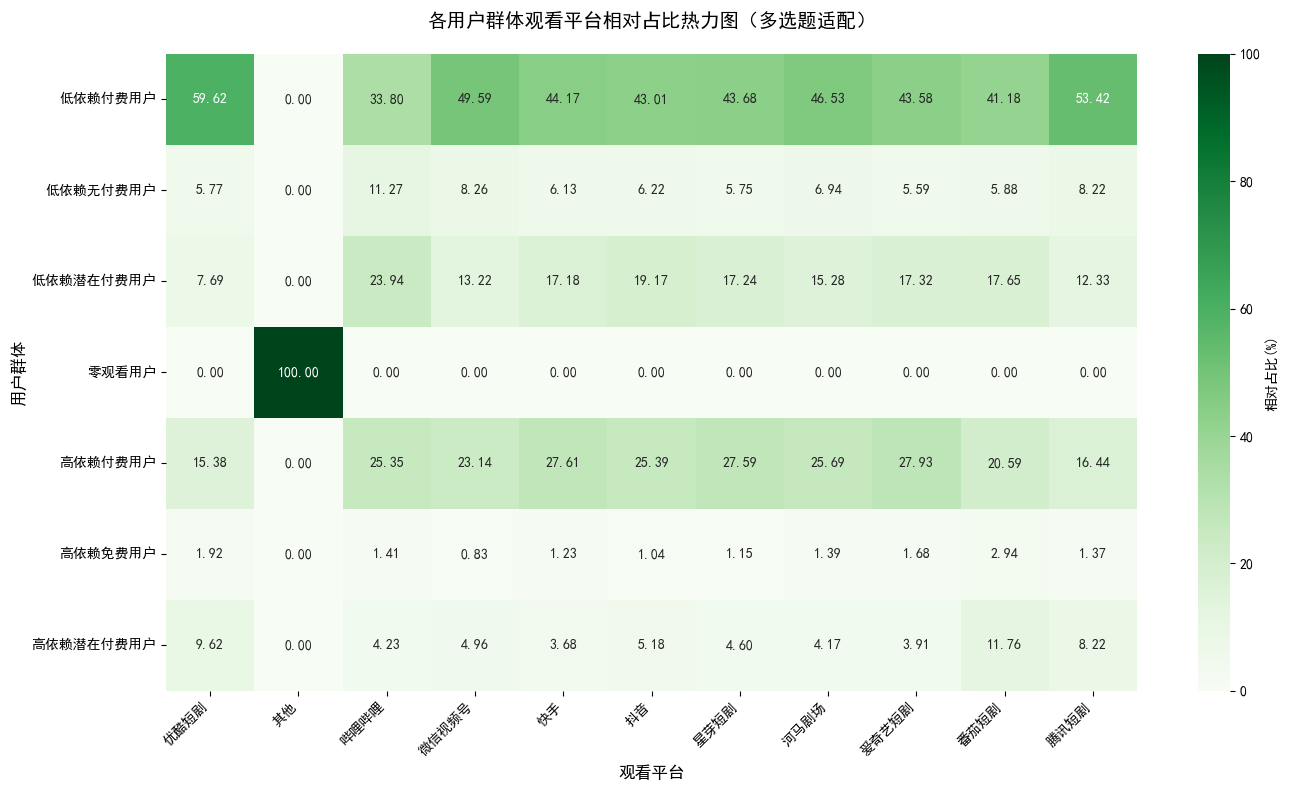

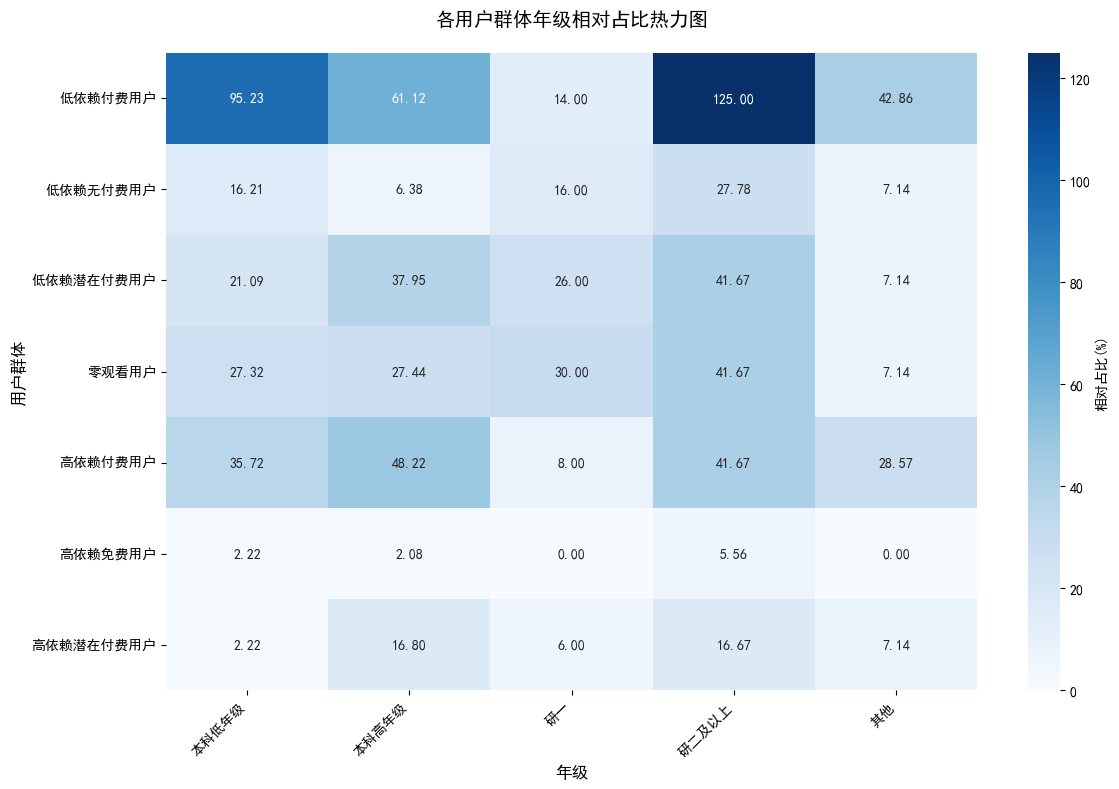

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------- 1. 完整数据读取与初始化（补全缺失逻辑） ----------------------
# 读取数据（务必替换为你的文件路径）
df = pd.read_excel("result.xlsx", sheet_name="Sheet1")

# 1.1 核心字段初始化（行为字段+人口统计字段）
core_cols = [
    # 行为字段（原有）
    " 您平均每周观看微短剧的时长约为",
    " 您观看微短剧的频率大致为",
    " 您过去一月为微短剧付费的总金额",
    " 您目前平均每周通过“广告解锁”观看微短剧的次数",
    " 您是否观看过微短剧",
    # 特征字段（人口统计）
    " 您的性别是",          # 示例：1=男，2=女
    " 您的年级是",          # 示例：1=大一，2=大二...9=其他
    " 您的专业是",          # 示例：1=文科，2=理科，3=工科，4=艺术类
]

# 1.2 精准筛选平台列（解决KeyError核心步骤）
# 步骤1：先打印df的所有列名，确认平台列的真实名称（方便核对）
print("=== 数据集中所有列名 ===")
for idx, col in enumerate(df.columns):
    print(f"{idx+1}. {col}")

# 步骤2：筛选平台列（仅保留df中实际存在的列）
platform_keywords = ["(抖音)", "(快手)", "(番茄短剧)", "(微信视频号)", "(哔哩哔哩)", 
                     "(腾讯短剧)", "(爱奇艺短剧)", "(优酷短剧)", "(星芽短剧)", "(河马剧场)", "(其他)"]
# 先筛选出df中包含平台关键词的列
platform_cols_candidate = [col for col in df.columns if any(kw in col for kw in platform_keywords)]
# 仅保留存在于df中的平台列，避免KeyError
platform_cols = [col for col in platform_cols_candidate if col in df.columns]
print(f"\n=== 识别到的平台列 ===")
print(platform_cols if platform_cols else "未识别到任何平台列！")

# 1.3 合并平台列到核心字段（仅当存在平台列时）
if platform_cols:
    core_cols += platform_cols
else:
    print("警告：未识别到任何平台列，平台特征统计将跳过！")

# 1.4 构建df_clean并处理缺失值（确保包含所有需要的列）
df_clean = df[core_cols].copy()

# 填充缺失值（补全并修复平台列填充）
# df_clean[" 您的性别是"] = df_clean[" 您的性别是"].fillna(0)
# df_clean[" 您的年级是"] = df_clean[" 您的年级是"].fillna(0)
# df_clean[" 您的专业是"] = df_clean[" 您的专业是"].fillna(0)
# 平台列填充0（未选），仅当存在平台列时执行
if platform_cols:
    df_clean[platform_cols] = df_clean[platform_cols].fillna(0)
# 行为字段填充
df_clean[[" 您过去一月为微短剧付费的总金额", " 您目前平均每周通过“广告解锁”观看微短剧的次数"]] = \
    df_clean[[" 您过去一月为微短剧付费的总金额", " 您目前平均每周通过“广告解锁”观看微短剧的次数"]].fillna(0)

# ---------------------- 2. 补全群体标签生成逻辑（避免用户群体列缺失） ----------------------
def define_watch_dependency(row):
    # 已观看用户：时长≥3小时（假设选项3对应≥3小时）且频率≥3次/周（选项3对应≥3次）
    if row[" 您是否观看过微短剧"] == 1:  # 1=观看过，2=未观看
        if row[" 您平均每周观看微短剧的时长约为"] >= 3 and row[" 您观看微短剧的频率大致为"] <= 3:
            return "高依赖"
        else:
            return "低依赖"
    else:
        return "零观看"

# 2.2 付费行为定义（有付费/仅广告解锁/无付费意愿）
def define_payment_behavior(row):
    """
    严格以「付费相关行为」定义，排除单纯观看意愿：
    1. 有付费：历史付费＞0（实际发生过付费）
    2. 仅广告解锁：无历史付费 + 每周广告解锁≥1次（免费但有观看行为）
    3. 无付费意愿：无历史付费 + 无广告解锁（既不付费也不看广告解锁，纯免费/零观看）
    """
    # 有付费：历史付费>0 或 未来愿意付费（假设≥3分为愿意，5分制）
    if row[" 您过去一月为微短剧付费的总金额"] > 1:
        return "有付费"
    # 仅广告解锁：广告解锁次数≥1 且 无付费行为
    elif row[" 您目前平均每周通过“广告解锁”观看微短剧的次数"] > 1:
        return "仅广告解锁"
    else:
        return "无付费"

def classify_user(row):
    if row["观看依赖度"] == "高依赖" and row["付费行为"] == "有付费":
        return "高依赖付费用户"
    elif row["观看依赖度"] == "高依赖" and row["付费行为"] == "仅广告解锁":
        return "高依赖潜在付费用户"
    elif row["观看依赖度"] == "高依赖" and row["付费行为"] == "无付费":
        return "高依赖免费用户"
    elif row["观看依赖度"] == "低依赖" and row["付费行为"] == "无付费":
        return "低依赖无付费用户"
    elif row["观看依赖度"] == "零观看":
        return "零观看用户"
    elif row["观看依赖度"] == "低依赖" and row["付费行为"] == "仅广告解锁":
        return "低依赖潜在付费用户"
    elif row["观看依赖度"] == "低依赖" and row["付费行为"] == "有付费":
        return "低依赖付费用户"
    else:
        return "其他"

# 生成群体标签（必须先执行，否则df_clean无"用户群体"列）
df_clean["观看依赖度"] = df_clean.apply(define_watch_dependency, axis=1)
df_clean["付费行为"] = df_clean.apply(define_payment_behavior, axis=1)
df_clean["用户群体"] = df_clean.apply(classify_user, axis=1)

# 剔除异常群体（仅保留7类核心群体）
df_clean = df_clean[df_clean["用户群体"] != "其他"]

# ---------------------- 3. 计算总体特征总数（分母） ----------------------
# 定义需要统计的特征列表（普通特征+平台特征）
normal_features = {
    "性别": " 您的性别是",
    "年级": " 您的年级是",
    "专业类别": " 您的专业是"
}
features = normal_features.copy()

# 3.1 平台特征预处理（仅当存在平台列时执行）
platform_name_map = {}
if platform_cols:
    # 简化平台列名（如“ 您主要通过哪些平台观看微短剧（可多选）(抖音)”→“抖音”）
    for col in platform_cols:
        for kw in platform_keywords:
            if kw in col:
                platform_name = kw.replace("(", "").replace(")", "")
                platform_name_map[col] = platform_name
                break

# 3.2 计算每个特征类别的总体数量
total_feature_counts = {}
# 普通特征（性别/年级/专业）：value_counts
for feat_name, feat_col in normal_features.items():
    total_feature_counts[feat_name] = df_clean[feat_col].value_counts().to_dict()

# 平台特征：sum（适配独热编码，计算总选择次数）
total_platform_counts = {}
if platform_cols:
    for col in platform_cols:
        # 双重校验：确保列在df_clean中
        if col not in df_clean.columns:
            print(f"警告：列{col}不在df_clean中，跳过！")
            continue
        platform_name = platform_name_map.get(col, col)  # 兜底：用原列名
        total_platform_counts[platform_name] = df_clean[col].sum()  # 求和=总选择次数
    total_feature_counts["观看平台"] = total_platform_counts  # 合并到总计数

# ---------------------- 4. 计算各群体的特征相对占比 ----------------------
# 初始化结果字典
group_feature_ratio = {}

# 遍历每个核心群体
groups = [
    "高依赖付费用户", "高依赖潜在付费用户", "高依赖免费用户",
    "低依赖付费用户", "低依赖潜在付费用户", "低依赖无付费用户",
    "零观看用户"
]

for group in groups:
    # 筛选该群体的样本
    group_df = df_clean[df_clean["用户群体"] == group]
    group_feature_ratio[group] = {}
    
    # 4.1 普通特征（性别/年级/专业）：原有逻辑
    for feat_name, feat_col in normal_features.items():
        group_feat_count = group_df[feat_col].value_counts().to_dict()
        ratio_dict = {}
        for feat_val, count in group_feat_count.items():
            if feat_val == 0:  # 跳过缺失值填充的0
                continue
            total_count = total_feature_counts[feat_name].get(feat_val, 1)  # 避免分母为0
            ratio = round(count / total_count * 100, 2)  # 保留2位小数
            ratio_dict[feat_val] = ratio
        group_feature_ratio[group][feat_name] = ratio_dict
    
    # 4.2 平台特征（独热编码）：仅当存在平台列时执行
    if platform_cols:
        ratio_dict = {}
        for col in platform_cols:
            if col not in df_clean.columns or col not in group_df.columns:
                continue
            platform_name = platform_name_map.get(col, col)
            # 群体内该平台的选择次数（求和）
            group_platform_count = group_df[col].sum()
            total_count = total_feature_counts["观看平台"].get(platform_name, 1)
            if total_count == 0:
                ratio = 0.0
            else:
                ratio = round(group_platform_count / total_count * 100, 2)
            ratio_dict[platform_name] = ratio
        group_feature_ratio[group]["观看平台"] = ratio_dict
    else:
        group_feature_ratio[group]["观看平台"] = {}

# ---------------------- 5. 结果格式化输出 ----------------------
# （1）打印文本版结果
print("\n=== 各用户群体特征相对占比统计（%）===")
print("说明：数值=「群体内某特征数 / 总体该特征数 × 100%」\n")

for group in groups:
    print(f"【{group}】")
    # 普通特征
    for feat_name in normal_features.keys():
        print(f"  {feat_name}：{group_feature_ratio[group].get(feat_name, {})}")
    # 平台特征
    print(f"  观看平台：{group_feature_ratio[group].get('观看平台', {})}")
    print("-" * 100)

# （2）整理为DataFrame并保存到Excel（更易阅读）
# 构建结果表格
result_rows = []
for group in groups:
    # 普通特征行
    for feat_name in normal_features.keys():
        feat_ratio = group_feature_ratio[group][feat_name]
        for feat_val, ratio in feat_ratio.items():
            result_rows.append({
                "用户群体": group,
                "特征类型": feat_name,
                "特征值": feat_val,
                "相对占比(%)": ratio
            })
    # 平台特征行（仅当存在平台列时）
    if platform_cols:
        feat_ratio = group_feature_ratio[group]["观看平台"]
        for feat_val, ratio in feat_ratio.items():
            result_rows.append({
                "用户群体": group,
                "特征类型": "观看平台",
                "特征值": feat_val,
                "相对占比(%)": ratio
            })

result_df = pd.DataFrame(result_rows)

# ========== 核心修改：年级数字→文字映射 ==========
# 定义年级映射字典
# grade_mapping = {
#     1: "大一",
#     2: "大二",
#     3: "大三",
#     4: "大四",
#     5: "研一",
#     6: "研二",
#     7: "研三",
#     8: "博士",
#     9: "其他"
# }
grade_mapping = {
    1: "本科低年级",
    2: "本科低年级",
    3: "本科高年级",
    4: "本科高年级",
    5: "研一",
    6: "研二及以上",
    7: "研二及以上",
    8: "研二及以上",
    9: "其他"
}
# 新增「特征值文本」列，对年级做映射，其他特征保留原值
result_df["特征值文本"] = result_df.apply(
    lambda x: grade_mapping.get(x["特征值"], x["特征值"]) if x["特征类型"] == "年级" else x["特征值"],
    axis=1
)

# 按用户群体+特征类型排序
result_df = result_df.sort_values(by=["用户群体", "特征类型"])
# 保存到Excel（包含映射后的文本）
result_df.to_excel("用户群体特征相对占比统计.xlsx", index=False)
print("\n统计结果已保存至：用户群体特征相对占比统计.xlsx")

# ---------------------- 6. 可视化：特征占比对比热力图 ----------------------
# 设置中文字体
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

# 6.1 性别热力图（原有）
gender_data = result_df[result_df["特征类型"] == "性别"].pivot(
    index="用户群体", columns="特征值", values="相对占比(%)"
)
plt.figure(figsize=(12, 8))
sns.heatmap(gender_data, annot=True, fmt=".2f", cmap="Reds", cbar_kws={"label": "相对占比(%)"})
plt.title("各用户群体性别相对占比热力图", fontsize=14, pad=20)
plt.xlabel("性别（1=男，2=女）", fontsize=12)
plt.ylabel("用户群体", fontsize=12)
plt.tight_layout()
# plt.savefig("用户群体性别占比热力图.png", dpi=300, bbox_inches="tight")
print("性别占比热力图已保存：用户群体性别占比热力图.png")

# 6.2 观看平台热力图（适配多选题，仅当存在平台列时执行）
if platform_cols and "观看平台" in result_df["特征类型"].values:
    platform_data = result_df[result_df["特征类型"] == "观看平台"].pivot(
        index="用户群体", columns="特征值", values="相对占比(%)"
    )
    plt.figure(figsize=(14, 8))
    sns.heatmap(platform_data, annot=True, fmt=".2f", cmap="Greens", cbar_kws={"label": "相对占比(%)"})
    plt.title("各用户群体观看平台相对占比热力图（多选题适配）", fontsize=14, pad=20)
    plt.xlabel("观看平台", fontsize=12)
    plt.ylabel("用户群体", fontsize=12)
    plt.xticks(rotation=45, ha="right")  # 平台名旋转避免重叠
    plt.tight_layout()
    # plt.savefig("用户群体平台占比热力图.png", dpi=300, bbox_inches="tight")
    print("平台占比热力图已保存：用户群体平台占比热力图.png")

# ========== 核心修改：年级热力图（使用映射后的文字横轴） ==========
# 6.3 年级热力图（替换为文字横轴）
# 6.3 年级热力图（使用映射后的文字横轴并保存）
# 替换单纯 pivot 为 pivot_table（遇到重复项时进行聚合）
grade_df = result_df[result_df["特征类型"] == "年级"].copy()
# 如果重复条目表示同一类的多个选择，通常用 sum；若是平均值用 mean，根据实际含义选择
grade_data = grade_df.pivot_table(
    index="用户群体",
    columns="特征值文本",
    values="相对占比(%)",
    aggfunc="sum",
    fill_value=0
)
grade_order = ["本科低年级", "本科高年级", "研一", "研二及以上", "其他"]
grade_data = grade_data.reindex(columns=[g for g in grade_order if g in grade_data.columns])

plt.figure(figsize=(12, 8))
sns.heatmap(grade_data, annot=True, fmt=".2f", cmap="Blues", cbar_kws={"label": "相对占比(%)"})
plt.title("各用户群体年级相对占比热力图", fontsize=14, pad=20)
plt.xlabel("年级", fontsize=12)
plt.ylabel("用户群体", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("用户群体年级占比热力图.png", dpi=300, bbox_inches="tight")
print("年级占比热力图已保存：用户群体年级占比热力图.png")


findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not fo

统计结果已保存至：特征类别下用户群体占比统计.xlsx


findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found

性别热力图已保存：性别特征下用户群体占比热力图.png


findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei

年级热力图已保存：年级特征下用户群体占比热力图.png


findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found

专业热力图已保存：专业特征下用户群体占比热力图.png


findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not fo

平台热力图已保存：平台特征下用户群体占比热力图.png


findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei

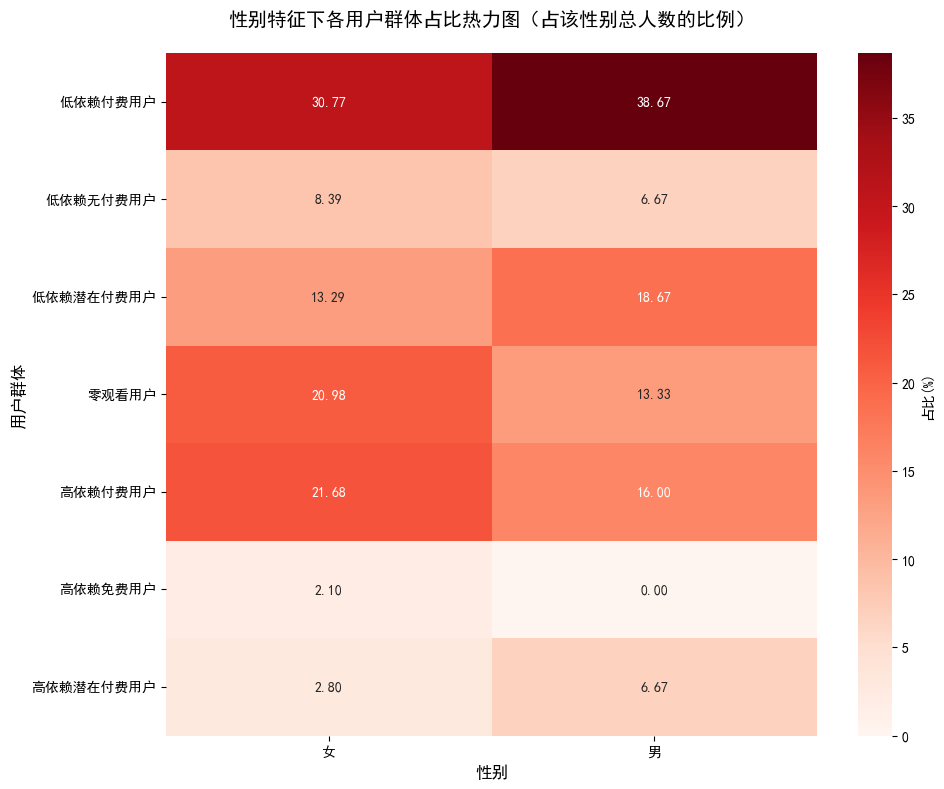

findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not fo

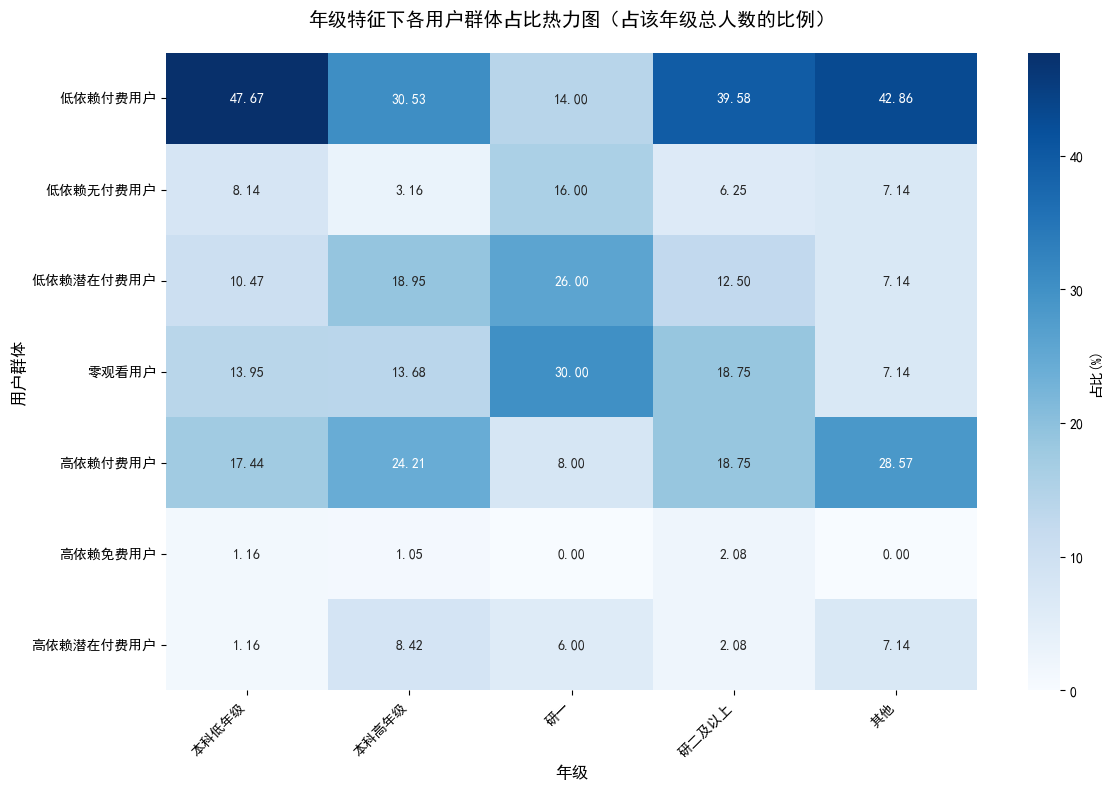

findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not fo

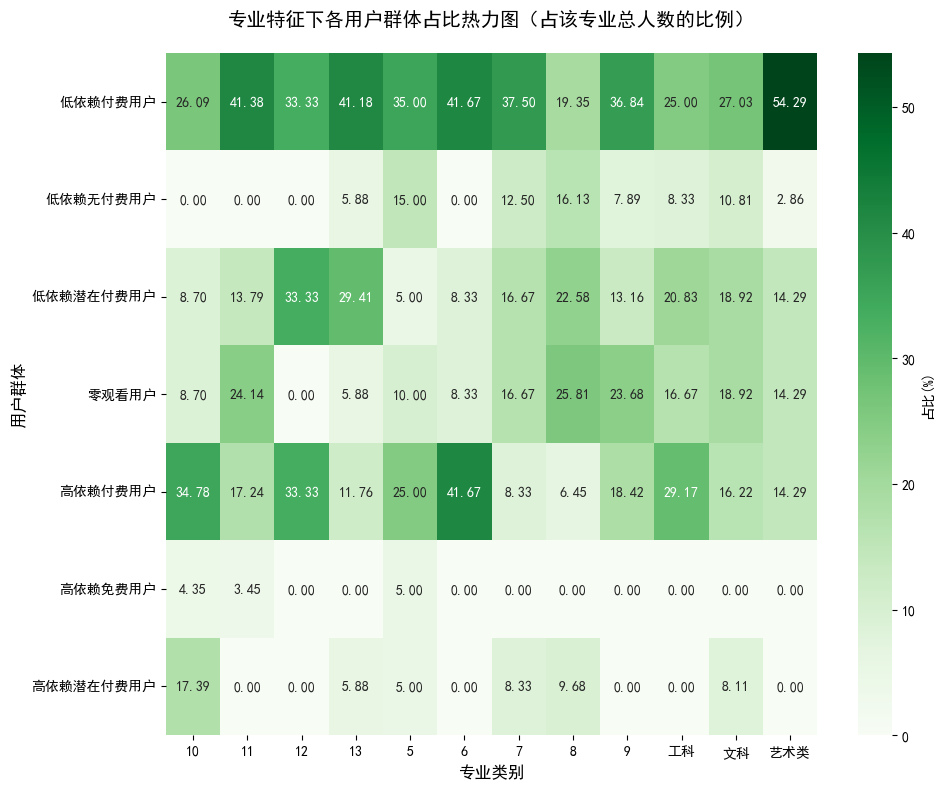

findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not fo

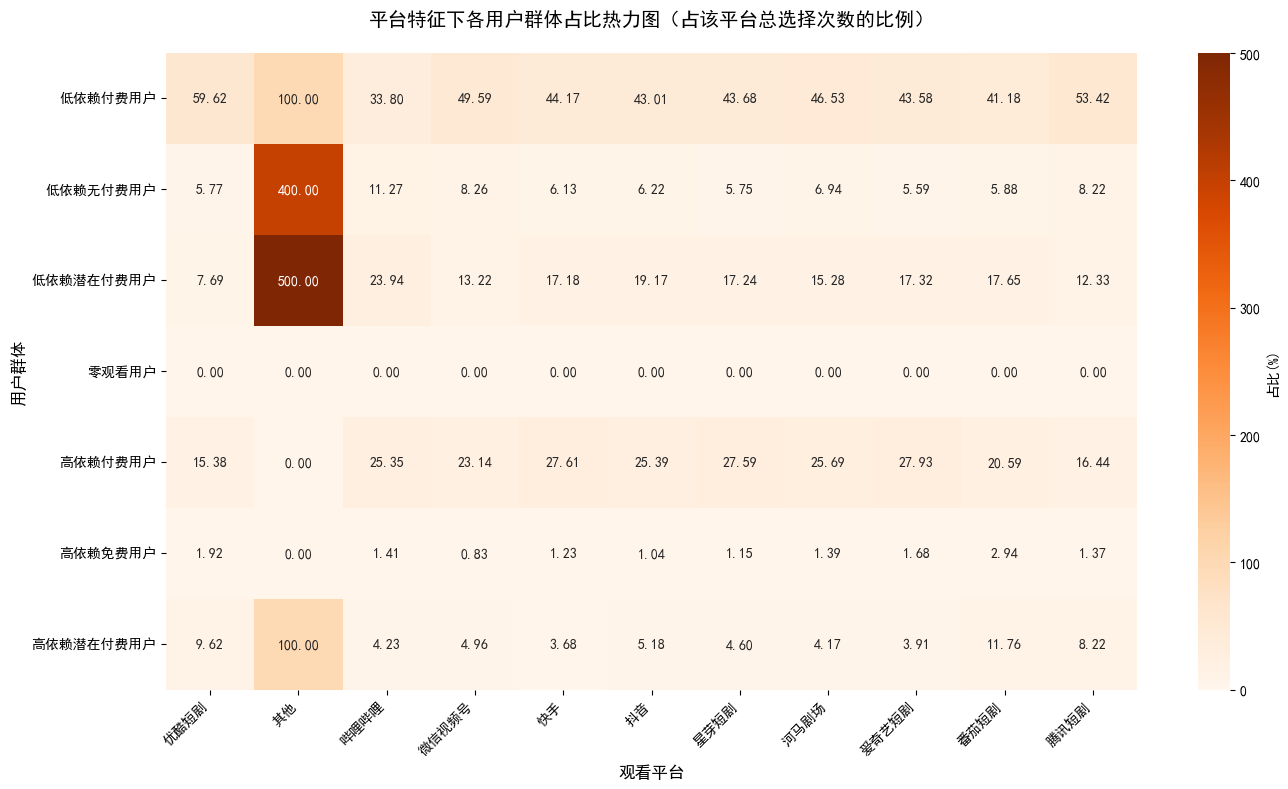

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# ---------------------- 3. 核心计算：特征类别下的群体占比（按用户需求） ----------------------
# 定义特征映射（含年级文本映射）
normal_features = {
    "性别": " 您的性别是",
    "年级": " 您的年级是",
    "专业类别": " 您的专业是"
}
grade_mapping = {
    1: "本科低年级",
    2: "本科低年级",
    3: "本科高年级",
    4: "本科高年级",
    5: "研一",
    6: "研二及以上",
    7: "研二及以上",
    8: "研二及以上",
    9: "其他"
}
platform_name_map = {}
if platform_cols:
    for col in platform_cols:
        for kw in platform_keywords:
            if kw in col:
                platform_name = kw.replace("(", "").replace(")", "")
                platform_name_map[col] = platform_name
                break

# 步骤1：计算各特征类别的总人数（分母）
feature_total_counts = {}

# 普通特征（性别/专业）：直接按原始值统计总人数
for feat_name, feat_col in [("性别", " 您的性别是"), ("专业类别", " 您的专业是")]:
    total_dict = df_clean[feat_col].value_counts().to_dict()
    # 过滤缺失值（0）
    feature_total_counts[feat_name] = {k: v for k, v in total_dict.items() if k != 0}

# 年级特征：按映射后的文本统计总人数（分母=映射后类别的总人数）
grade_original_total = df_clean[" 您的年级是"].value_counts().to_dict()
grade_mapped_total = {}
for mapped_name in grade_mapping.values():
    # 汇总该映射名称下所有原始值的人数
    total = sum([grade_original_total.get(orig_val, 0) for orig_val, map_val in grade_mapping.items() if map_val == mapped_name])
    if total > 0:  # 只保留有人数的类别
        grade_mapped_total[mapped_name] = total
feature_total_counts["年级"] = grade_mapped_total

# 平台特征：按平台名称统计总选择次数（分母=该平台总选择次数）
if platform_cols:
    platform_total = {}
    for col in platform_cols:
        platform_name = platform_name_map.get(col, col)
        total_count = df_clean[col].sum()
        if total_count > 0:
            platform_total[platform_name] = total_count
    feature_total_counts["观看平台"] = platform_total

# 步骤2：计算每个特征类别下各群体的占比
groups = [
    "高依赖付费用户", "高依赖潜在付费用户", "高依赖免费用户",
    "低依赖付费用户", "低依赖潜在付费用户", "低依赖无付费用户",
    "零观看用户"
]
result_rows = []

# 3.1 性别特征（原始值：1=男，2=女）
feat_name = "性别"
feat_col = " 您的性别是"
for feat_val, total_count in feature_total_counts[feat_name].items():
    for group in groups:
        # 该群体在该性别下的人数
        group_count = len(df_clean[(df_clean["用户群体"] == group) & (df_clean[feat_col] == feat_val)])
        # 占比=群体人数/该性别总人数 ×100%
        ratio = round(group_count / total_count * 100, 2) if total_count > 0 else 0.0
        result_rows.append({
            "特征类型": feat_name,
            "特征值": feat_val,
            "特征值文本": "男" if feat_val == 1 else "女" if feat_val == 2 else str(feat_val),
            "用户群体": group,
            "占比(%)": ratio
        })

# 3.2 专业特征（原始值：1=文科，2=理科，3=工科，4=艺术类）
feat_name = "专业类别"
feat_col = " 您的专业是"
major_mapping = {1: "文科", 2: "理科", 3: "工科", 4: "艺术类"}
for feat_val, total_count in feature_total_counts[feat_name].items():
    for group in groups:
        group_count = len(df_clean[(df_clean["用户群体"] == group) & (df_clean[feat_col] == feat_val)])
        ratio = round(group_count / total_count * 100, 2) if total_count > 0 else 0.0
        result_rows.append({
            "特征类型": feat_name,
            "特征值": feat_val,
            "特征值文本": major_mapping.get(feat_val, str(feat_val)),
            "用户群体": group,
            "占比(%)": ratio
        })

# 3.3 年级特征（映射后文本：本科低年级、本科高年级等）
feat_name = "年级"
feat_col = " 您的年级是"
for mapped_name, total_count in feature_total_counts[feat_name].items():
    for group in groups:
        # 该群体在该映射年级下的人数（汇总所有原始值）
        orig_vals = [k for k, v in grade_mapping.items() if v == mapped_name]
        group_count = len(df_clean[(df_clean["用户群体"] == group) & (df_clean[feat_col].isin(orig_vals))])
        ratio = round(group_count / total_count * 100, 2) if total_count > 0 else 0.0
        result_rows.append({
            "特征类型": feat_name,
            "特征值": mapped_name,
            "特征值文本": mapped_name,
            "用户群体": group,
            "占比(%)": ratio
        })

# 3.4 平台特征（映射后名称：抖音、快手等）
if platform_cols:
    feat_name = "观看平台"
    for platform_name, total_count in feature_total_counts[feat_name].items():
        # 找到该平台对应的列
        platform_col = next((col for col in platform_cols if platform_name_map.get(col) == platform_name), None)
        if not platform_col:
            continue
        for group in groups:
            # 该群体在该平台的选择次数（独热编码求和）
            group_count = df_clean[df_clean["用户群体"] == group][platform_col].sum()
            ratio = round(group_count / total_count * 100, 2) if total_count > 0 else 0.0
            result_rows.append({
                "特征类型": feat_name,
                "特征值": platform_name,
                "特征值文本": platform_name,
                "用户群体": group,
                "占比(%)": ratio
            })

# 构建结果DataFrame并保存
result_df = pd.DataFrame(result_rows)
result_df = result_df.sort_values(by=["特征类型", "特征值", "用户群体"])
result_df.to_excel("特征类别下用户群体占比统计.xlsx", index=False)
print("统计结果已保存至：特征类别下用户群体占比统计.xlsx")

# ---------------------- 4. 可视化：热力图（横轴=特征类别，纵轴=用户群体） ----------------------
# 设置中文字体（兼容多系统）
plt.rcParams["font.family"] = ["SimHei", "WenQuanYi Micro Hei", "Heiti TC", "Arial Unicode MS"]
plt.rcParams["axes.unicode_minus"] = False

# 4.1 性别热力图（横轴=男/女，纵轴=用户群体，同一横轴占比和=100%）
gender_data = result_df[result_df["特征类型"] == "性别"].pivot(
    index="用户群体", columns="特征值文本", values="占比(%)"
)
if not gender_data.empty:
    plt.figure(figsize=(10, 8))
    sns.heatmap(gender_data, annot=True, fmt=".2f", cmap="Reds", cbar_kws={"label": "占比(%)"})
    plt.title("性别特征下各用户群体占比热力图（占该性别总人数的比例）", fontsize=14, pad=20)
    plt.xlabel("性别", fontsize=12)
    plt.ylabel("用户群体", fontsize=12)
    plt.tight_layout()
    plt.savefig("性别特征下用户群体占比热力图.png", dpi=300, bbox_inches="tight")
    print("性别热力图已保存：性别特征下用户群体占比热力图.png")

# 4.2 年级热力图（横轴=年级文本，纵轴=用户群体）
grade_data = result_df[result_df["特征类型"] == "年级"].pivot(
    index="用户群体", columns="特征值文本", values="占比(%)"
)
if not grade_data.empty:
    grade_order = ["本科低年级", "本科高年级", "研一", "研二及以上", "其他"]
    grade_data = grade_data.reindex(columns=[g for g in grade_order if g in grade_data.columns])
    plt.figure(figsize=(12, 8))
    sns.heatmap(grade_data, annot=True, fmt=".2f", cmap="Blues", cbar_kws={"label": "占比(%)"})
    plt.title("年级特征下各用户群体占比热力图（占该年级总人数的比例）", fontsize=14, pad=20)
    plt.xlabel("年级", fontsize=12)
    plt.ylabel("用户群体", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig("年级特征下用户群体占比热力图.png", dpi=300, bbox_inches="tight")
    print("年级热力图已保存：年级特征下用户群体占比热力图.png")

# 4.3 专业特征热力图
major_data = result_df[result_df["特征类型"] == "专业类别"].pivot(
    index="用户群体", columns="特征值文本", values="占比(%)"
)
if not major_data.empty:
    plt.figure(figsize=(10, 8))
    sns.heatmap(major_data, annot=True, fmt=".2f", cmap="Greens", cbar_kws={"label": "占比(%)"})
    plt.title("专业特征下各用户群体占比热力图（占该专业总人数的比例）", fontsize=14, pad=20)
    plt.xlabel("专业类别", fontsize=12)
    plt.ylabel("用户群体", fontsize=12)
    plt.tight_layout()
    plt.savefig("专业特征下用户群体占比热力图.png", dpi=300, bbox_inches="tight")
    print("专业热力图已保存：专业特征下用户群体占比热力图.png")

# 4.4 平台特征热力图
if platform_cols and "观看平台" in result_df["特征类型"].values:
    platform_data = result_df[result_df["特征类型"] == "观看平台"].pivot(
        index="用户群体", columns="特征值文本", values="占比(%)"
    )
    if not platform_data.empty:
        plt.figure(figsize=(14, 8))
        sns.heatmap(platform_data, annot=True, fmt=".2f", cmap="Oranges", cbar_kws={"label": "占比(%)"})
        plt.title("平台特征下各用户群体占比热力图（占该平台总选择次数的比例）", fontsize=14, pad=20)
        plt.xlabel("观看平台", fontsize=12)
        plt.ylabel("用户群体", fontsize=12)
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.savefig("平台特征下用户群体占比热力图.png", dpi=300, bbox_inches="tight")
        print("平台热力图已保存：平台特征下用户群体占比热力图.png")

plt.show()